<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

## *Data Science Unit 4 Sprint 3 Lesson 3*
# Autoencoders

__Problem:__ Is it possible to automatically represent an image as a fixed-sized vector even if it isn’t labeled?

__Solution:__ Use an autoencoder

Why do we need to represent an image as a fixed-sized vector do you ask? 

* __Information Retrieval__
    - [Reverse Image Search](https://en.wikipedia.org/wiki/Reverse_image_search)
    - [Recommendation Systems - Content Based Filtering](https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering)
* __Dimensionality Reduction__
    - [Feature Extraction](https://www.kaggle.com/c/vsb-power-line-fault-detection/discussion/78285)
    - [Manifold Learning](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)

We've already seen *representation learning* when we talked about word embedding modelings during our NLP week. Today we're going to achieve a similiar goal on images using *autoencoders*. An autoencoder is a neural network that is trained to attempt to copy its input to its output. Usually they are restricted in ways that allow them to copy only approximately. The model often learns useful properties of the data, because it is forced to prioritize which aspecs of the input should be copied. The properties of autoencoders have made them an important part of modern generative modeling approaches. Consider autoencoders a special case of feed-forward networks (the kind we've been studying); backpropagation and gradient descent still work. 

## Learning Objectives
*At the end of the lecture you should be to*:
* <a href="#p1">Part 1</a>: Describe the componenets of an autoencoder
* <a href="#p2">Part 2</a>: Train an autoencoder
* <a href="#p3">Part 3</a>: Apply an autoenocder to a basic information retrieval problem

<a id="p1"></a>

## Autoencoder Architecture

The *encoder* compresses the input data and the *decoder* does the reverse to produce the uncompressed version of the data to create a reconstruction of the input as accurately as possible:

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=800/>

The learning process gis described simply as minimizing a loss function: 
$ L(x, g(f(x))) $

- $L$ is a loss function penalizing $g(f(x))$ for being dissimiliar from $x$ (such as mean squared error)
- $f$ is the encoder function
- $g$ is the decoder function


<a id="p2"></a>
## Training an Autoencoder

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file
from tensorflow.keras.optimizers import Adam

from struct import unpack
import json
import glob

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from io import BytesIO
import PIL
from PIL import ImageDraw

from IPython.display import clear_output, Image, display, HTML

In [2]:
BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
path = get_file('cat', BASE_PATH + 'cat.bin')

A drawing is a list of strokes, each made up of a series of x and y coordinates. The x and y coordinates are stored separately, so we need to zip them into a list to feed into the ImageDraw object we just created:

In [3]:
def load_icons(path, train_size=0.85):
    x = []
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white')
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]
                draw.line(points, fill=0, width=2)
            img = img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)


x_train, x_test = load_icons(path)
x_train.shape, x_test.shape

((104721, 32, 32, 1), (18481, 32, 32, 1))

In [4]:
def create_autoencoder():
    input_img = Input(shape=(32, 32, 1))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)

    x = Dense(channels)(x)

    for i in range(4):
        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels //= 2
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_autoencoder()
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 4)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 8)    0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 104721 samples, validate on 18481 samples
Epoch 1/100
104721/104721 [==============================] - 56s 532us/sample - loss: 0.6834 - val_loss: 0.6711
Epoch 2/100
104721/104721 [==============================] - 56s 539us/sample - loss: 0.6367 - val_loss: 0.5989
Epoch 3/100
104721/104721 [==============================] - 56s 532us/sample - loss: 0.5895 - val_loss: 0.5836
Epoch 4/100
104721/104721 [==============================] - 56s 536us/sample - loss: 0.5779 - val_loss: 0.5740
Epoch 5/100
104721/104721 [==============================] - 56s 538us/sample - loss: 0.5695 - val_loss: 0.5669
Epoch 6/100
104721/104721 [==============================] - 57s 540us/sample - loss: 0.5633 - val_loss: 0.5616
Epoch 7/100
104721/104721 [==============================] - 57s 544us/sample - loss: 0.5587 - val_loss: 0.5577
Epoch 8/100
104721/104721 [==============================] - 57s 547us/sample - loss: 0.5552 - val_loss: 0.5547
Epoch 9/100
104721/104721 [==========================

In [8]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

(25, 32, 32, 1)

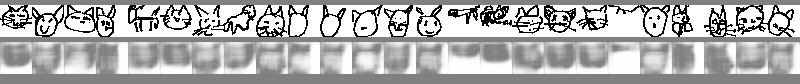

In [9]:
def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))

<a id="p3"></a>
## Part 3: Information Retrieval with Autoencoders

Let's slice our autoendoer in half to extract our reduced features. :) 

In [11]:
from tensorflow.keras.models import Model

layer_name = 'dense'

intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(x_train)

In [ ]:
# Loop Over Each Input Observation


In [ ]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
nn.fit(vectors)